# **Classification of 90 Different Faces of Animals**

## Reading the data from the dataset

In [1]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2024-03-31 18:06:05.716579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 18:06:05.716682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 18:06:05.846396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Creating a Dataframe using dataset

In [2]:
path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 

## Spliting Dataset into Train & Test

In [3]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Removing old index columns
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Displaying train dataframe
print(train_df[["imgpath", "labels"]].head())

#Checking the shape of dataframe
print(train_df.shape)

                                             imgpath       labels
0  /kaggle/input/animal-image-dataset-90-differen...     elephant
1  /kaggle/input/animal-image-dataset-90-differen...      hamster
2  /kaggle/input/animal-image-dataset-90-differen...  caterpillar
3  /kaggle/input/animal-image-dataset-90-differen...     hedgehog
4  /kaggle/input/animal-image-dataset-90-differen...          rat
(3779, 2)


## Checking Image Data

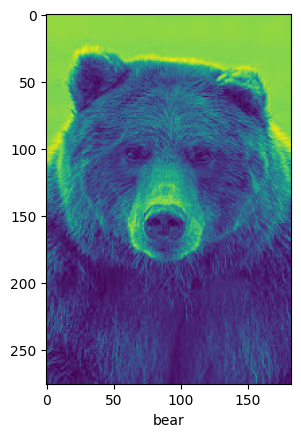

In [4]:
filepath = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/bear"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()   
    break

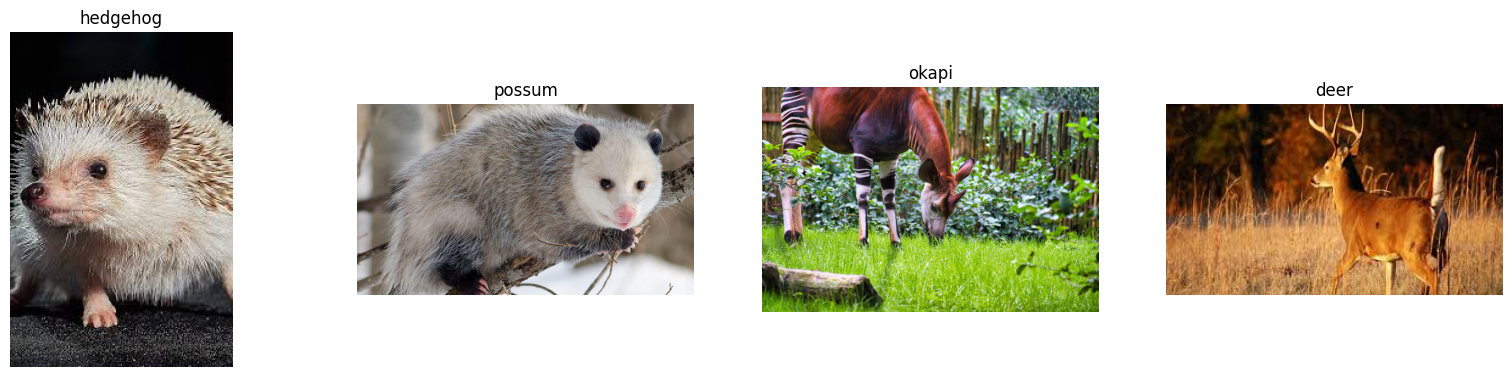

In [5]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

## Defining augmentation and dataloaders

In [6]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.


## VGG Model

In [7]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False


58889256/58889256 [==============================] - 2s 0us/step


In [8]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
sequence = tf.keras.Sequential()


inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [9]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10


I0000 00:00:1711908391.147985      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 119s 474ms/step - loss: 5.1309 - accuracy: 0.0153 - val_loss: 4.7281 - val_accuracy: 0.0185
Epoch 2/10
237/237 [==============================] - 78s 328ms/step - loss: 4.7682 - accuracy: 0.0280 - val_loss: 4.6091 - val_accuracy: 0.0291
Epoch 3/10
237/237 [==============================] - 75s 318ms/step - loss: 4.4803 - accuracy: 0.0453 - val_loss: 4.5993 - val_accuracy: 0.0273
Epoch 4/10
237/237 [==============================] - 73s 307ms/step - loss: 4.2594 - accuracy: 0.0717 - val_loss: 4.5077 - val_accuracy: 0.0353
Epoch 5/10
237/237 [==============================] - 71s 299ms/step - loss: 4.0416 - accuracy: 0.1037 - val_loss: 4.4550 - val_accuracy: 0.0397
Epoch 6/10
237/237 [==============================] - 70s 297ms/step - loss: 3.8744 - accuracy: 0.1238 - val_loss: 4.6110 - val_accuracy: 0.0450
Epoch 7/10
237/237 [==============================] - 71s 301ms/step - loss: 3.7097 - accuracy: 0.1485 - val_loss: 4.4650 - val_accuracy: 0.

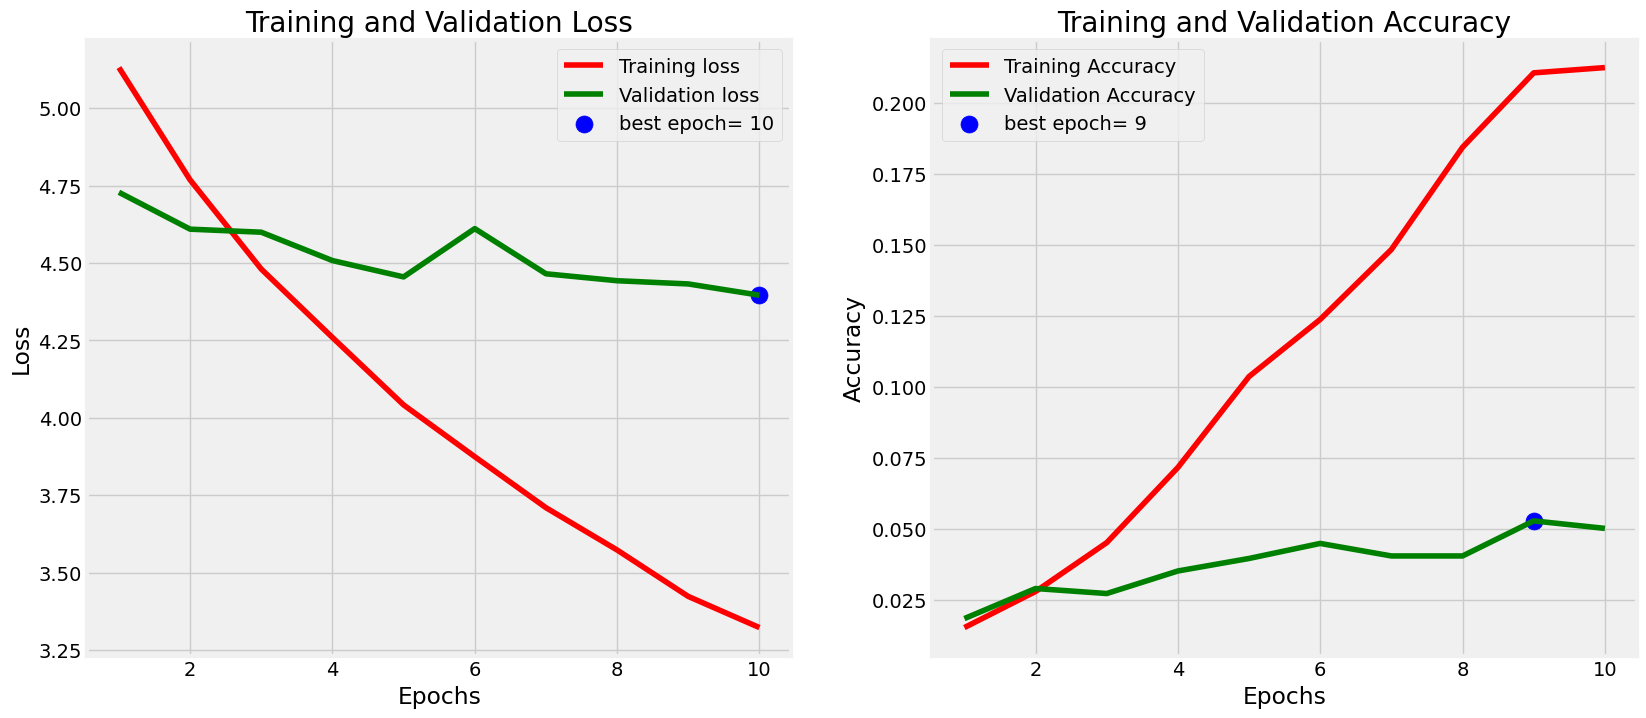

In [10]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [11]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 13.21939
Test Accuracy: 3.70%


In [12]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 10.38773
Test Accuracy: 4.31%


## ResNET

In [13]:
# Load the pretained model
pretrained_resnet = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_resnet.layers):
    pretrained_resnet.layers[i].trainable = False


94765736/94765736 [==============================] - 3s 0us/step


In [14]:
num_classes = len(set(train_images.classes))


sequence = tf.keras.Sequential()
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_resnet(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model_resnet = Model(inputs=inputs, outputs=outputs)


model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                           

In [15]:
history_resnet = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model_resnet.save_weights('./checkpoints/my_checkpoint2')

Epoch 1/10
237/237 [==============================] - 91s 363ms/step - loss: 5.2981 - accuracy: 0.0280 - val_loss: 4.3979 - val_accuracy: 0.0626
Epoch 2/10
237/237 [==============================] - 71s 300ms/step - loss: 4.4456 - accuracy: 0.0730 - val_loss: 3.7353 - val_accuracy: 0.1376
Epoch 3/10
237/237 [==============================] - 71s 300ms/step - loss: 3.8276 - accuracy: 0.1315 - val_loss: 3.3047 - val_accuracy: 0.2337
Epoch 4/10
237/237 [==============================] - 73s 307ms/step - loss: 3.4193 - accuracy: 0.1990 - val_loss: 2.9379 - val_accuracy: 0.3254
Epoch 5/10
237/237 [==============================] - 72s 303ms/step - loss: 3.0660 - accuracy: 0.2694 - val_loss: 2.6551 - val_accuracy: 0.3889
Epoch 6/10
237/237 [==============================] - 72s 305ms/step - loss: 2.7869 - accuracy: 0.3257 - val_loss: 2.5185 - val_accuracy: 0.4436
Epoch 7/10
237/237 [==============================] - 71s 299ms/step - loss: 2.6076 - accuracy: 0.3607 - val_loss: 2.2724 - val_ac

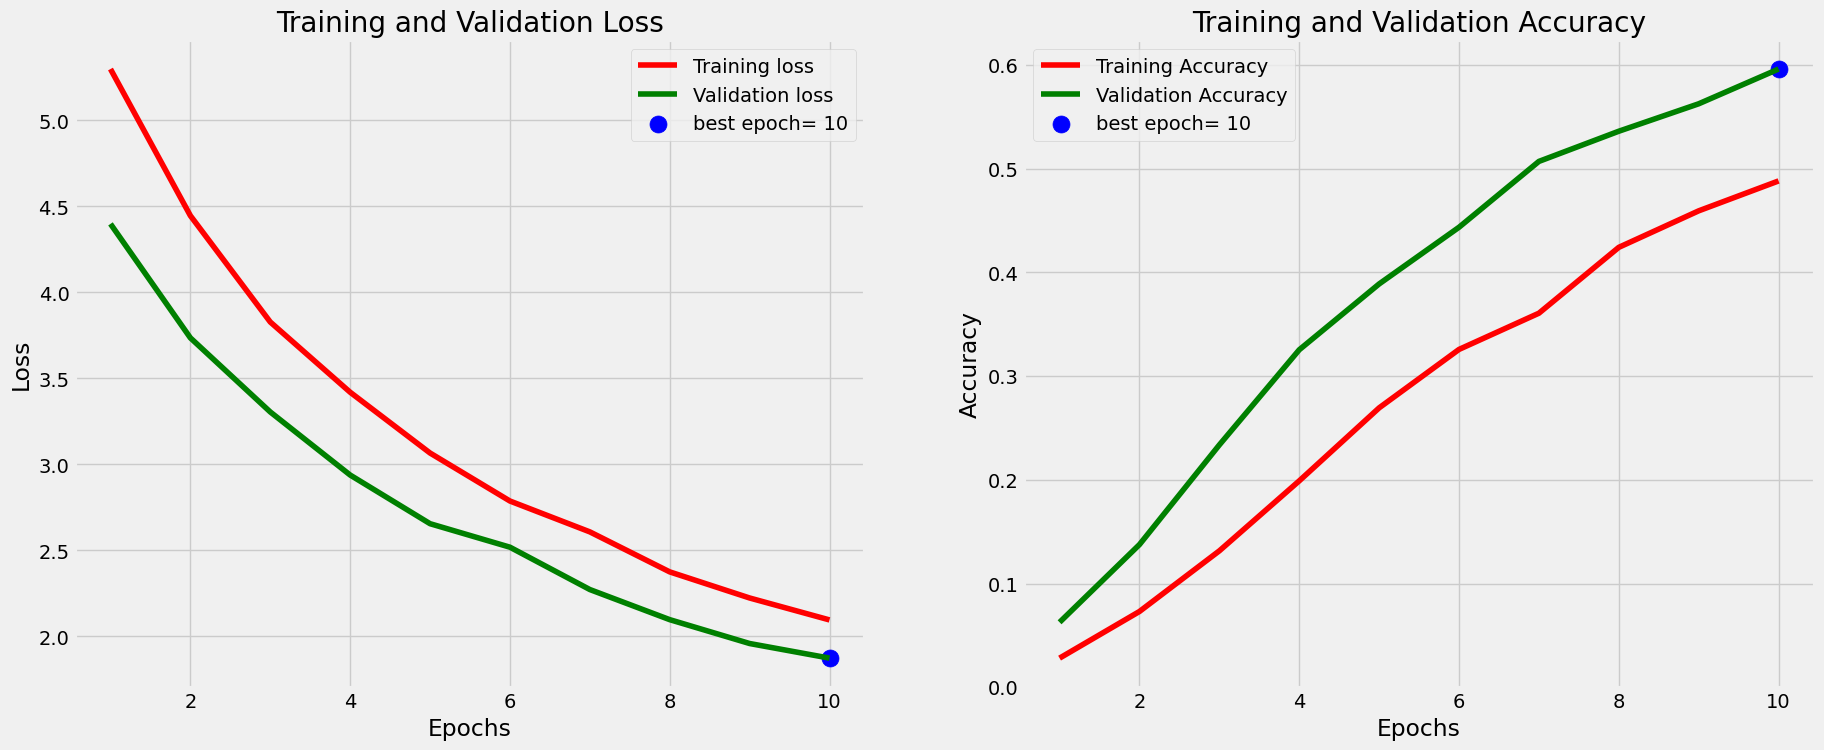

In [16]:
tr_acc = history_resnet.history['accuracy']
tr_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [17]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 1.86688
Test Accuracy: 58.52%


In [18]:
pretrained_resnet.trainable = True
for layer in pretrained_resnet.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_resnet.layers[:10]:
    print(l.name, l.trainable)

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())
history = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model_resnet.save_weights('./checkpoints/my_checkpoint3')


input_2 True
conv1_pad True
conv1_conv True
conv1_bn False
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn False
conv2_block1_1_relu True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_norm

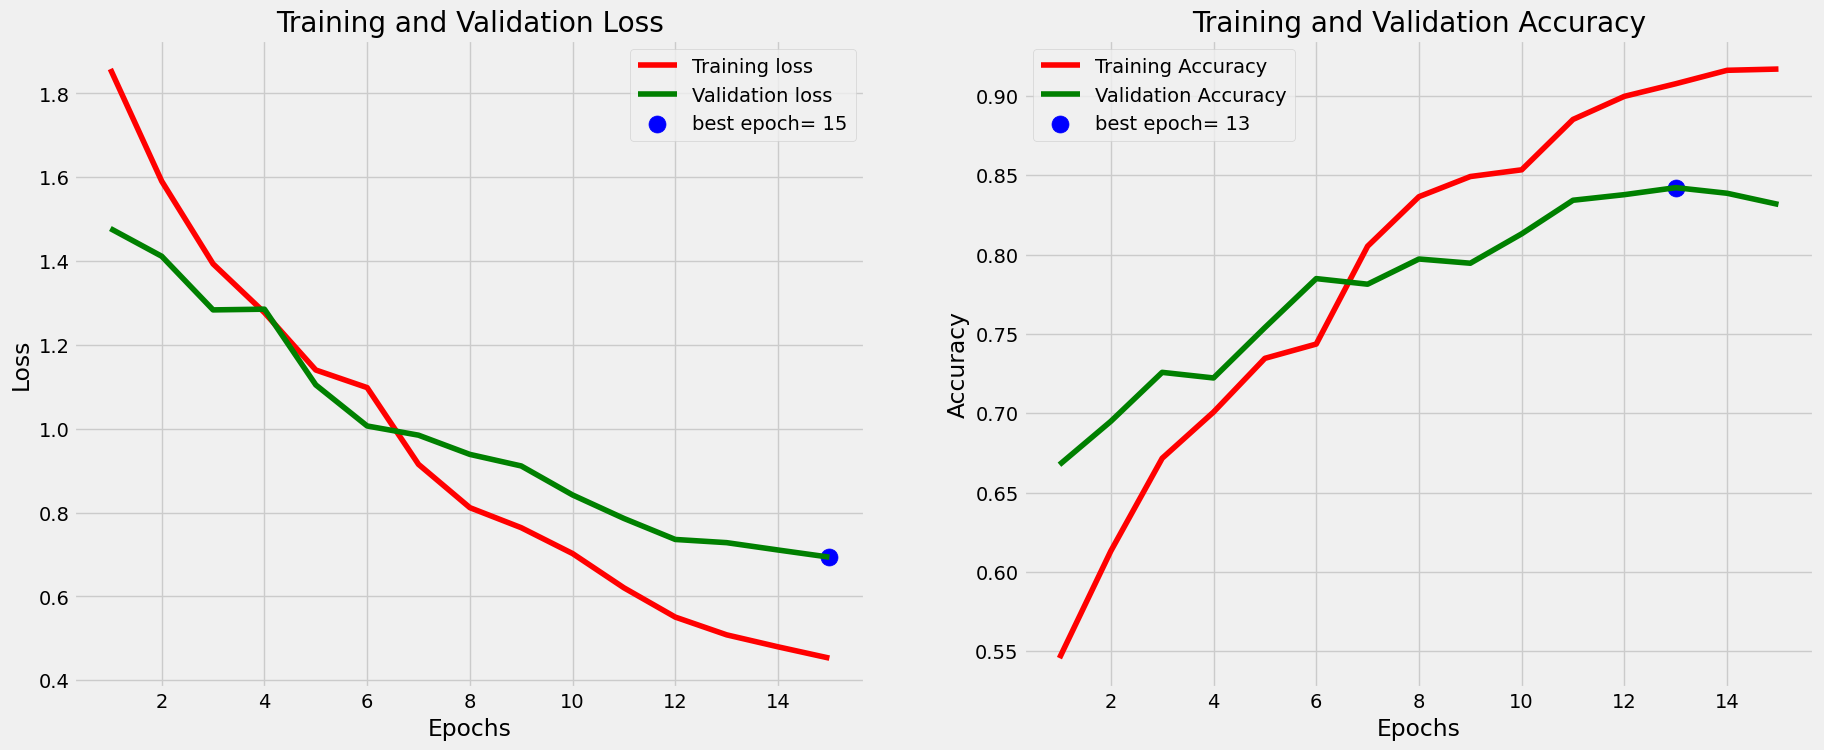

In [19]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [20]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.67479
Test Accuracy: 83.98%


In [21]:
y_true = test_images.classes
y_pred = np.argmax(model_resnet.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

31/31 [==============================] - 8s 229ms/step
F1 Score: 0.8348131657548581
                precision    recall  f1-score   support

      antelope       0.67      0.40      0.50         5
        badger       1.00      1.00      1.00         7
           bat       0.50      0.67      0.57         3
          bear       0.80      1.00      0.89         4
           bee       1.00      1.00      1.00         5
        beetle       0.67      1.00      0.80         4
         bison       1.00      0.50      0.67         4
          boar       0.75      1.00      0.86         3
     butterfly       1.00      1.00      1.00         4
           cat       0.88      0.88      0.88         8
   caterpillar       0.67      1.00      0.80         2
    chimpanzee       1.00      0.86      0.92         7
     cockroach       1.00      0.86      0.92         7
           cow       0.50      0.67      0.57         3
        coyote       0.83      0.83      0.83         6
          crab     

In [22]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_resnet.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

31/31 [==============================] - 7s 228ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           53        okapi                 53   
1            1           83       turkey                 83   
2            2           74        shark                 74   
3            3           44     ladybugs                 44   
4            4           57           ox                 57   
5            5           59        panda                 59   
6            6           68          rat                 33   
7            7           13          cow                 75   

  Prediction Classes                                               Path  \
0              okapi  /kaggle/input/animal-image-dataset-90-differen...   
1             turkey  /kaggle/input/animal-image-dataset-90-differen...   
2              shark  /kaggle/input/animal-image-dataset-90-differen...   
3           ladybugs  /kaggle/input/animal-image-dataset-90-differen...   
4                 ox  /kaggle/input/animal-image-dataset-90-differen...   
5              panda  /kaggle/input/animal-image-dataset-90-differen...   
6            hamster  /kaggle/input/animal-image-dataset-90-differen...   
7              sheep  /kaggle/input/animal-image-dataset-90-differen...   

   Prediction Probability  
0                0.706249  
1                0.961160  
2                0.232653  
3                0.990582  
4                0.283453  
5                0.890599  
6                0.424106  
7                0.456722

## Correct Predictions

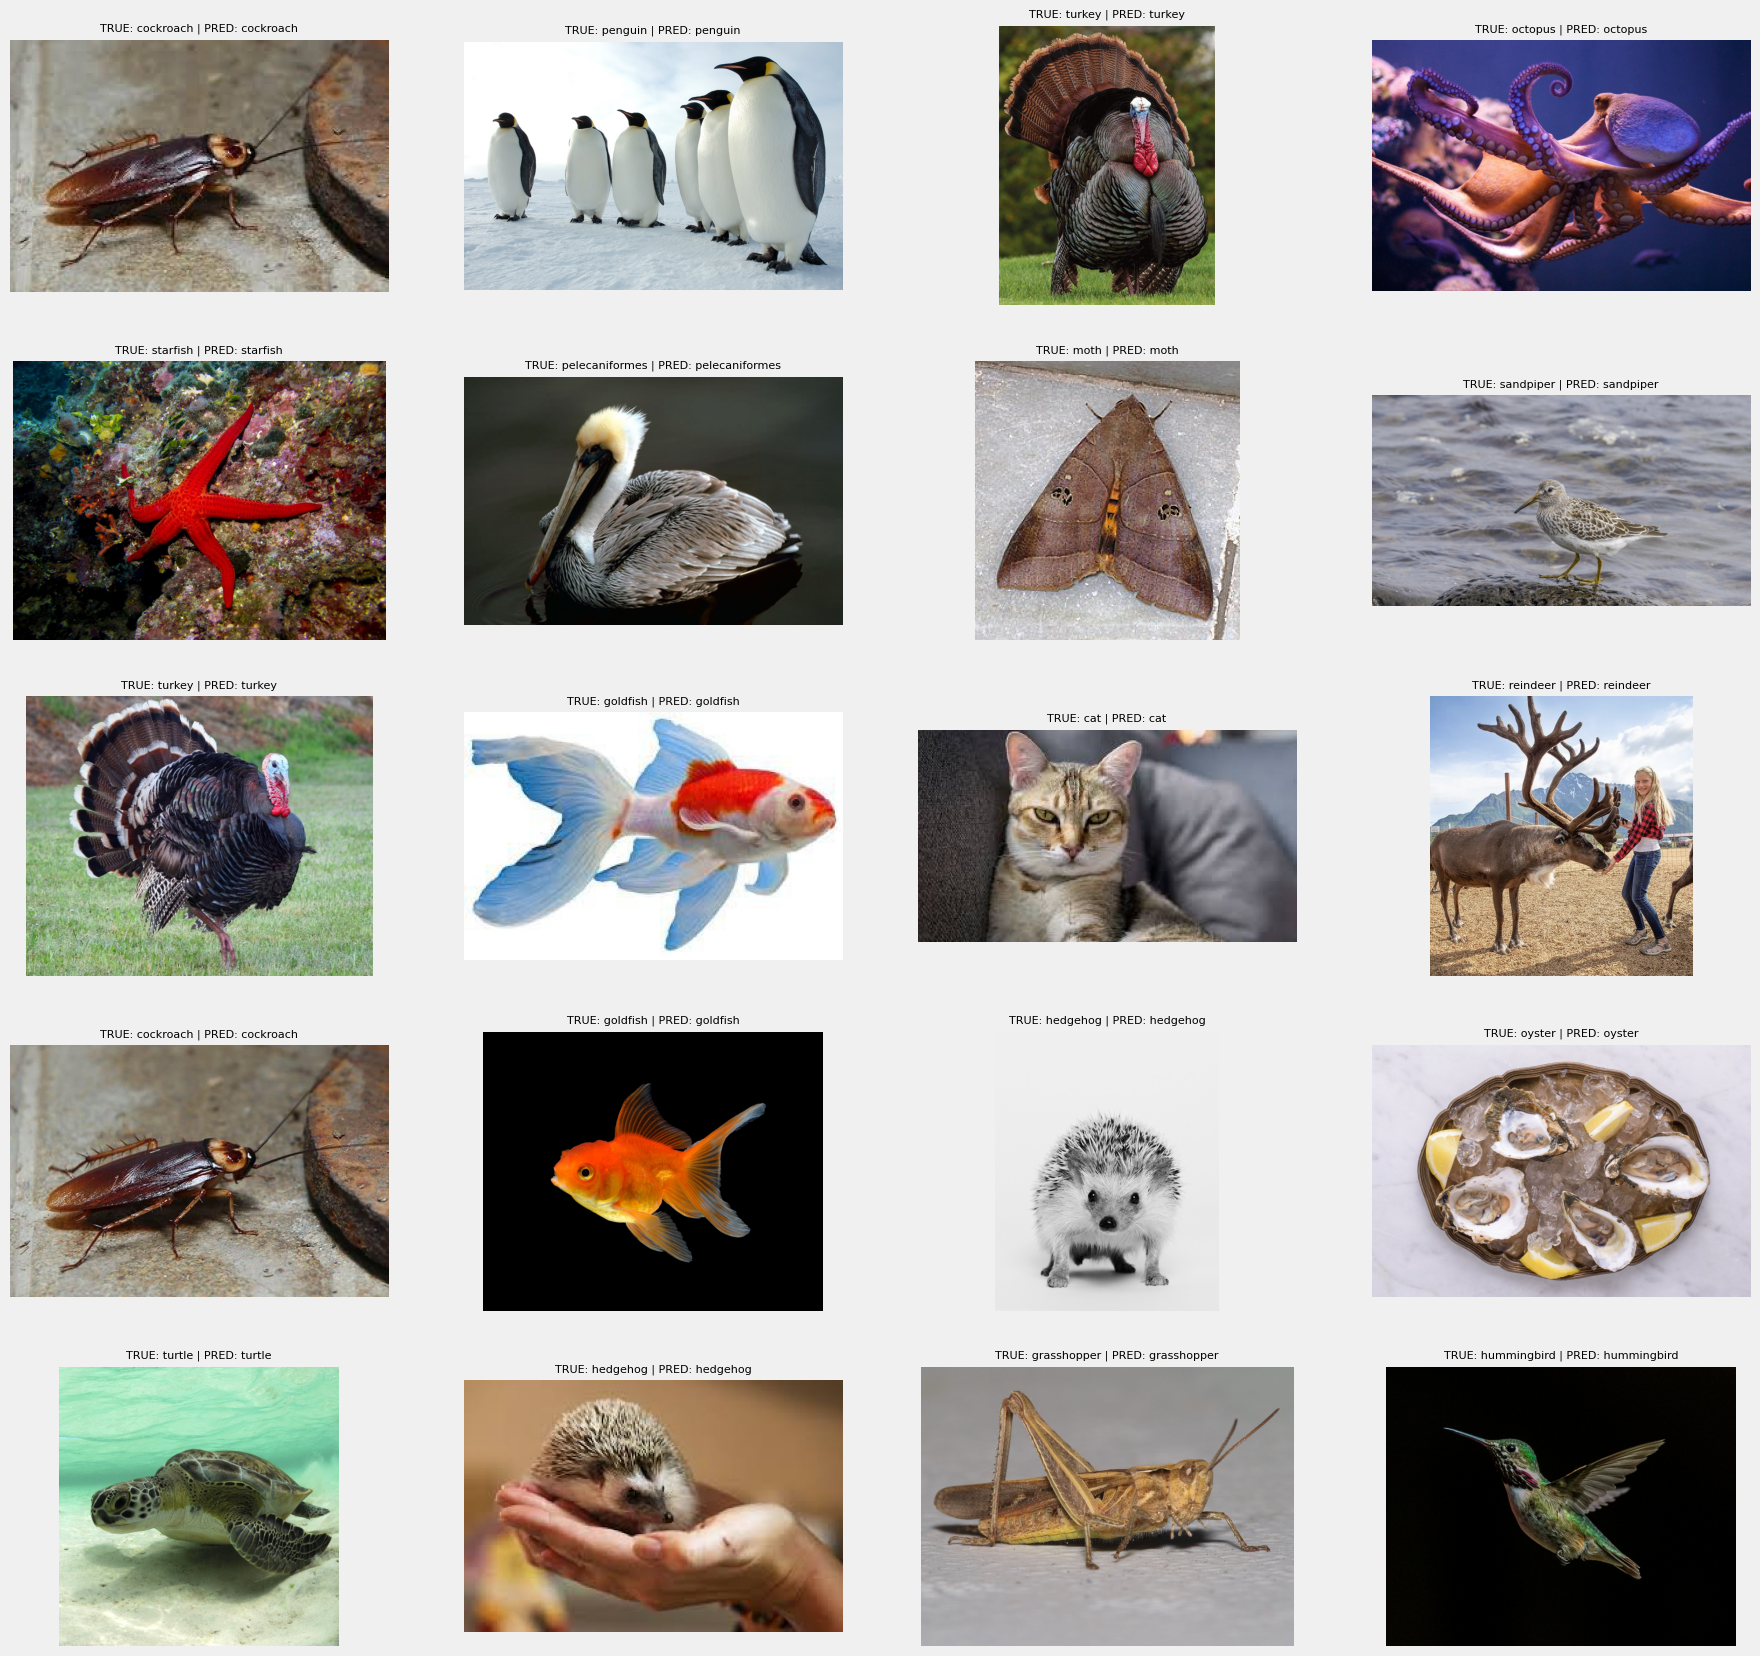

In [23]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] == Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

## Errors

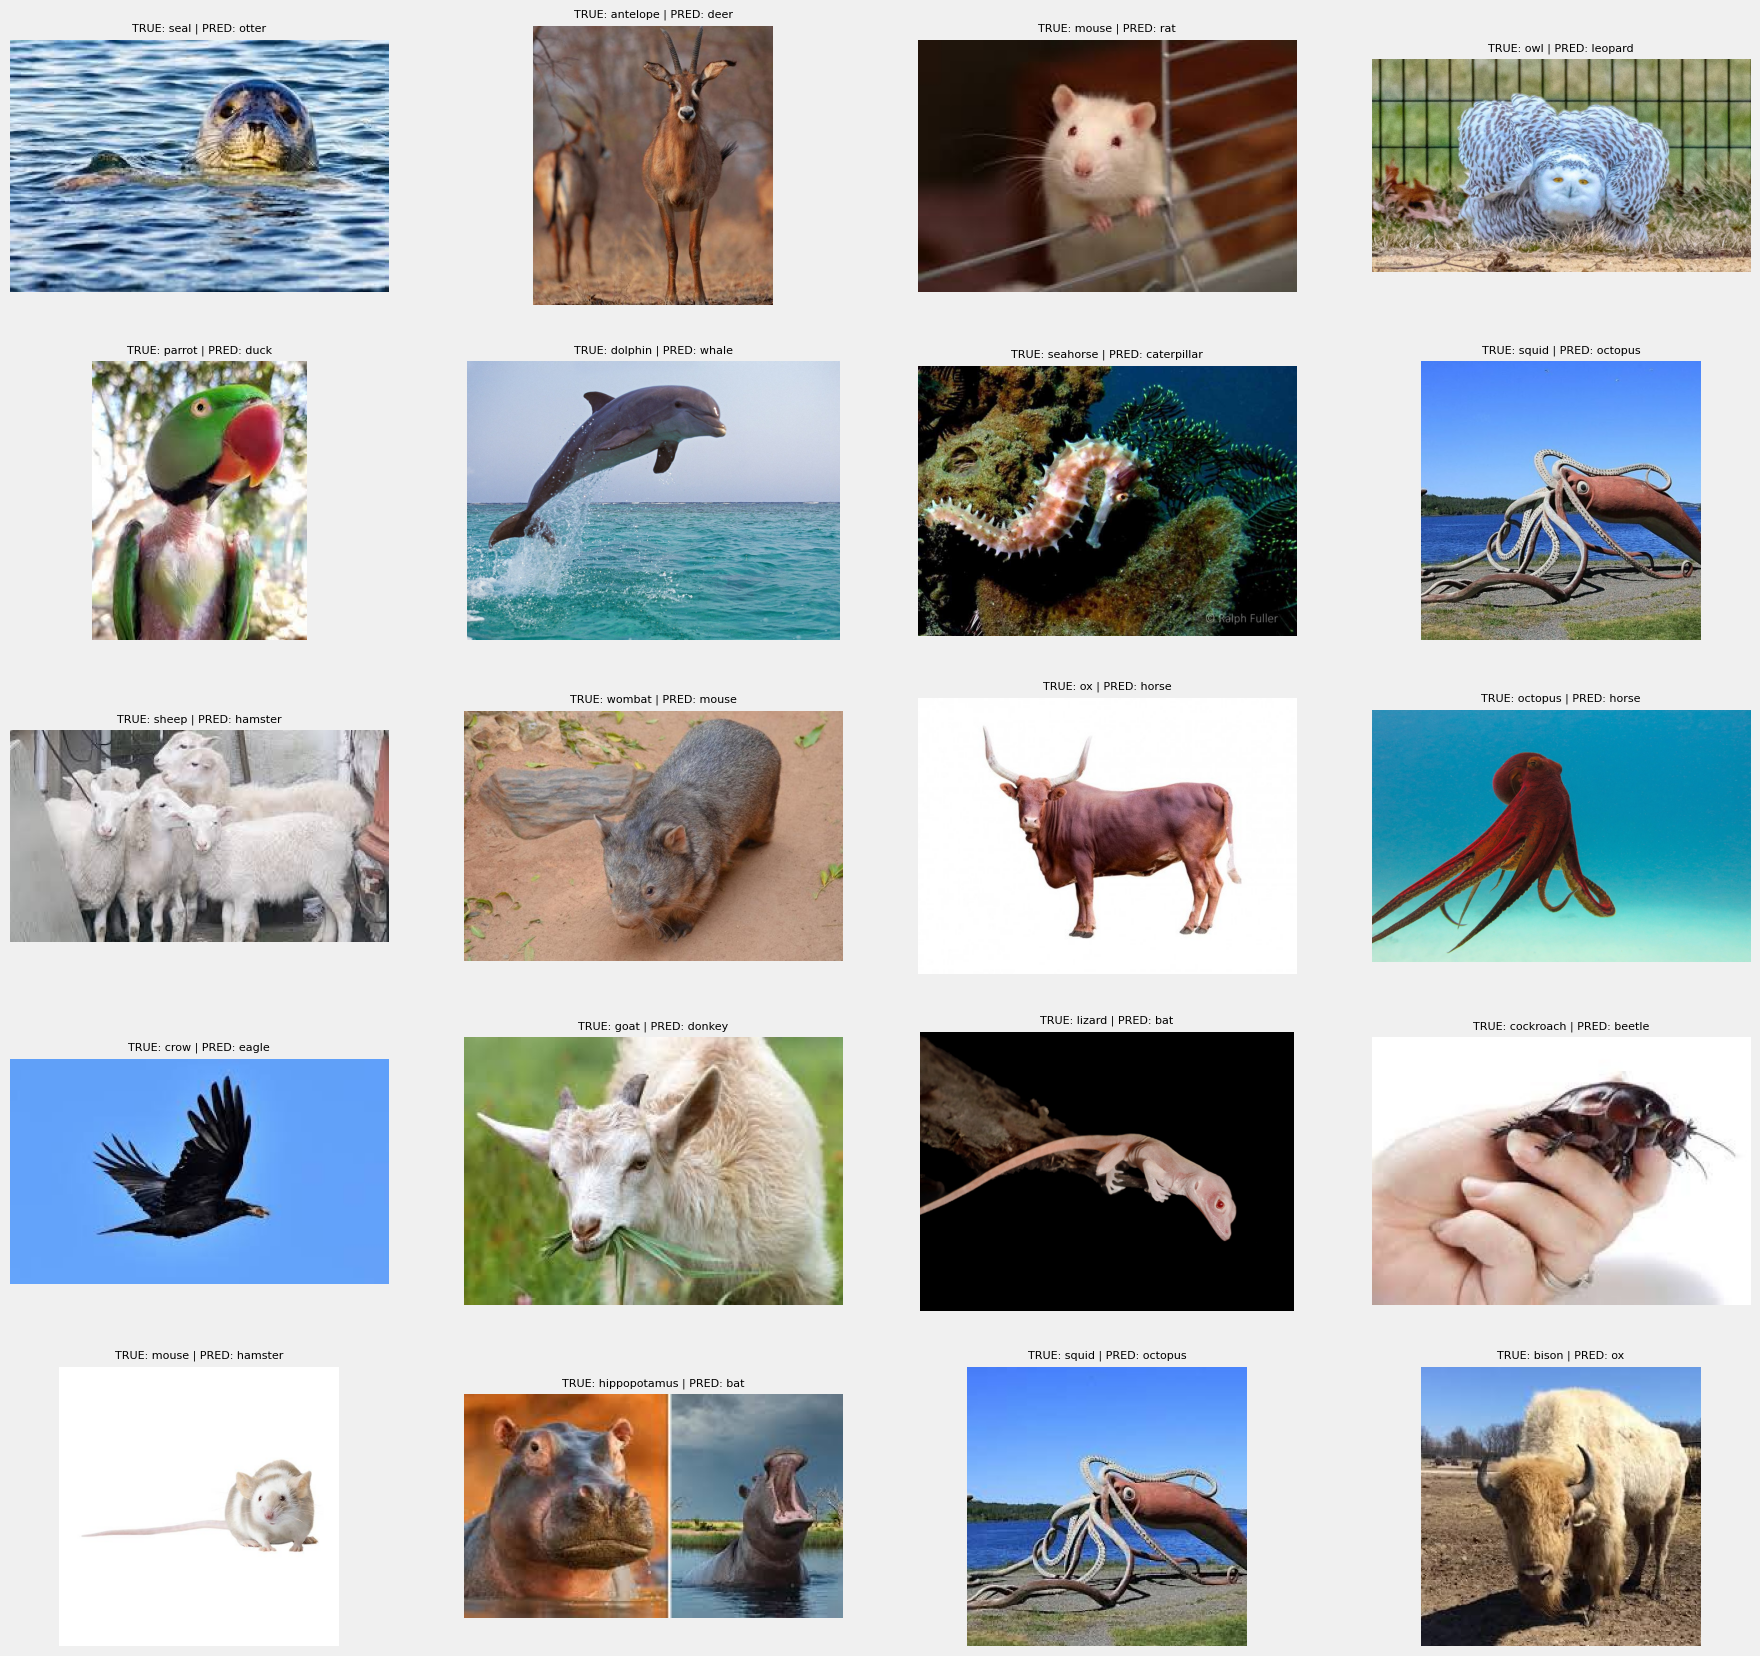

In [24]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()